In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def make_regridder(ds, ds_base, variable, algorithm='bilinear'):   
    if 'latitude' in ds[variable].dims:
       ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'}).set_coords(['lon', 'lat'])
    ds_regrid = xr.Dataset({'lat': (['lat'], np.arange(np.floor(ds_base['lat'].min().values*10)/10, np.ceil(ds_base['lat'].max().values*10)/10, 0.01)),
                     'lon': (['lon'], np.arange(np.floor(ds_base['lon'].min().values*10)/10, np.ceil(ds_base['lon'].max().values*10)/10, 0.01)),
                    }
                   )

    regridder = xe.Regridder(ds, ds_regrid, algorithm)
    regridder.clean_weight_file()
    return regridder

### Create base grid using NO2 dataset

In [3]:
ds_s5p = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/starter_pack/s5p_no2/no2_1year.nc')
ds_no2_clouds = ds_s5p[['NO2_column_number_density', 'cloud_fraction']]
no2_regridder = make_regridder(ds_no2_clouds, ds_no2_clouds, 'NO2_column_number_density')
ds_base_regrid = no2_regridder(ds_no2_clouds)
ds_base_regrid = ds_base_regrid.where(ds_base_regrid['NO2_column_number_density']!=0.)

Create weight file: bilinear_148x475_71x231.nc
Remove file bilinear_148x475_71x231.nc
using dimensions ('lat', 'lon') from data variable NO2_column_number_density as the horizontal dimensions for this dataset.


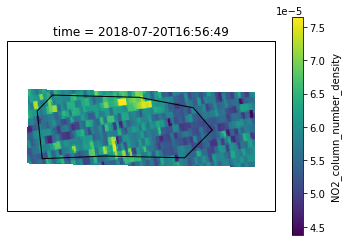

In [4]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_regrid.NO2_column_number_density.isel(time=20).plot(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines()
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [5]:
def find_boundaries(ds):
    print('Min Lat', ds.lat.min().values)
    print('Max Lat', ds.lat.max().values)
    print('Min Lon', ds.lon.min().values)
    print('Max Lon', ds.lon.max().values) 

### Create land mask for base grid

In [6]:
#Download Super High Resolution SST file (0.01 degree grid)
#https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplG1SST.nc?SST[(2017-09-13T00:00:00Z):1:(2017-09-13T00:00:00Z)][(17.005):1:(19.005)][(-69.995):1:(-64.005)],mask[(2017-09-13T00:00:00Z):1:(2017-09-13T00:00:00Z)][(17.005):1:(19.005)][(-69.995):1:(-64.005)],analysis_error[(2017-09-13T00:00:00Z):1:(2017-09-13T00:00:00Z)][(17.005):1:(19.005)][(-69.995):1:(-64.005)]

In [7]:
ds_sea = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/jplG1SST_e435_8209_9395.nc')

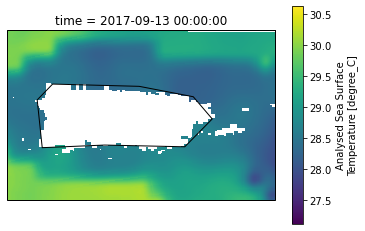

In [8]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_sea.SST.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree());
ax.coastlines()
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [9]:
sea_regridder = make_regridder(ds_sea, ds_base_regrid, 'SST')
ds_sea_regrid = sea_regridder(ds_sea)
ds_sea_regrid = ds_sea_regrid.where(ds_sea_regrid['SST']!=0.)

Create weight file: bilinear_201x600_81x241.nc
Remove file bilinear_201x600_81x241.nc
using dimensions ('latitude', 'longitude') from data variable SST as the horizontal dimensions for this dataset.


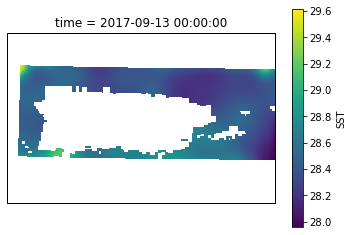

In [10]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_sea_regrid.SST.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [11]:
land_ones = ds_sea_regrid.SST.isel(time=0).fillna(1)
land_mask = land_ones.where(land_ones ==1.)
land_mask = land_mask.where(land_mask.lat<18.5)
land_mask = land_mask.drop('time')
ds_base_regrid.coords['land_mask'] = land_mask

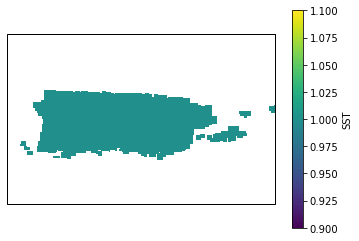

In [12]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
land_mask.plot(ax=ax, transform=ccrs.PlateCarree());
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

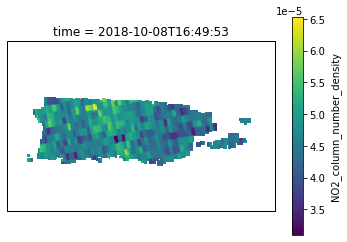

In [13]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_regrid['NO2_column_number_density'].isel(time=103).where(ds_base_regrid.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

### Compute daily averages

In [14]:
ds_base = ds_base_regrid.resample(time='1D').mean()

//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


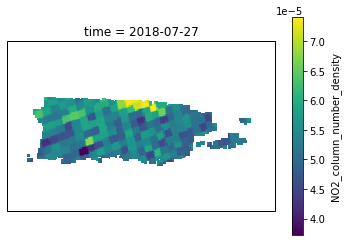

In [15]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base['NO2_column_number_density'].isel(time=26).where(ds_base.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

### Add wind speed

In [16]:
ds_gfs = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/starter_pack/gfs/gfs_1year.nc')
ds_gfs = ds_gfs.drop('crs')
gfs_regridder = make_regridder(ds_gfs, ds_base_regrid, 'temperature_2m_above_ground')
ds_gfs_regrid = gfs_regridder(ds_gfs)
ds_gfs_regrid = ds_gfs_regrid.where(ds_gfs_regrid['temperature_2m_above_ground']!=0.)
ds_gfs_regrid.coords['land_mask'] = land_mask
ds_gfs_regrid['wind_speed'] = np.sqrt(np.square(ds_gfs_regrid.u_component_of_wind_10m_above_ground) + np.square(ds_gfs_regrid.v_component_of_wind_10m_above_ground))

Create weight file: bilinear_148x475_81x241.nc
Remove file bilinear_148x475_81x241.nc
using dimensions ('lat', 'lon') from data variable temperature_2m_above_ground as the horizontal dimensions for this dataset.


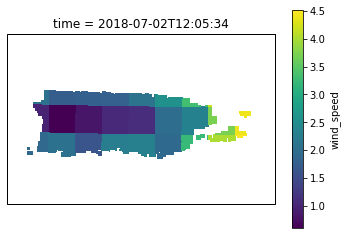

In [17]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_gfs_regrid['wind_speed'].isel(time=6).where(ds_gfs_regrid.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [18]:
ds_gfs_daily_mean = ds_gfs_regrid.resample(time='1D').mean()
ds_gfs_daily_max = ds_gfs_regrid.resample(time='1D').max()
ds_gfs_daily_min = ds_gfs_regrid.resample(time='1D').min()


//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
ds_gfs_regrid

<xarray.Dataset>
Dimensions:                               (lat: 81, lon: 241, time: 1460)
Coordinates:
  * time                                  (time) datetime64[ns] 2018-07-01T00:05:31 ... 2019-06-30T18:16:38
  * lon                                   (lon) float64 -67.4 -67.39 ... -65.0
  * lat                                   (lat) float64 17.9 17.91 ... 18.7
    land_mask                             (lat, lon) float64 nan nan ... nan nan
Data variables:
    temperature_2m_above_ground           (time, lat, lon) float64 nan ... nan
    specific_humidity_2m_above_ground     (time, lat, lon) float64 nan ... nan
    relative_humidity_2m_above_ground     (time, lat, lon) float64 nan ... nan
    u_component_of_wind_10m_above_ground  (time, lat, lon) float64 nan ... nan
    v_component_of_wind_10m_above_ground  (time, lat, lon) float64 nan ... nan
    precipitable_water_entire_atmosphere  (time, lat, lon) float64 nan ... nan
    wind_speed                            (time, lat, lon) float64 nan ... nan
Attributes:
    regrid_method:  bilinear

In [20]:
ds_base['wind_speed_mean'] = ds_gfs_daily_mean['wind_speed']
ds_base['gfs_temp_mean'] = ds_gfs_daily_mean['temperature_2m_above_ground']
ds_base['gfs_temp_max'] = ds_gfs_daily_max['temperature_2m_above_ground']
ds_base['gfs_temp_min'] = ds_gfs_daily_min['temperature_2m_above_ground']
ds_base['gfs_humidity_mean'] = ds_gfs_daily_mean['specific_humidity_2m_above_ground']
ds_base['gfs_rain_max'] = ds_gfs_daily_max['precipitable_water_entire_atmosphere']

### Add in weather

In [21]:
ds_gldas = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/starter_pack/gldas/gldas_1year.nc')
ds_gldas = ds_gldas.drop('crs')
gldas_regridder = make_regridder(ds_gldas, ds_base_regrid, 'Tair_f_inst',  'nearest_s2d')
ds_gldas_regrid = gldas_regridder(ds_gldas)
ds_gldas_regrid = ds_gldas_regrid.where(ds_gldas_regrid['Tair_f_inst']!=0.)
ds_gldas_regrid.coords['land_mask'] = land_mask

Create weight file: nearest_s2d_148x475_81x241.nc
Remove file nearest_s2d_148x475_81x241.nc
using dimensions ('lat', 'lon') from data variable LWdown_f_tavg as the horizontal dimensions for this dataset.


In [22]:
ds_gldas_regrid_fill = ds_gldas_regrid.ffill(dim='lat')
ds_gldas_regrid_fill = ds_gldas_regrid_fill.bfill(dim='lat')
ds_gldas_regrid_fill = ds_gldas_regrid_fill.ffill(dim='lon')
ds_gldas_regrid_fill = ds_gldas_regrid_fill.bfill(dim='lon')

//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/missing.py:410: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)
//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/missing.py:427: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  ).transpose(*arr.dims)


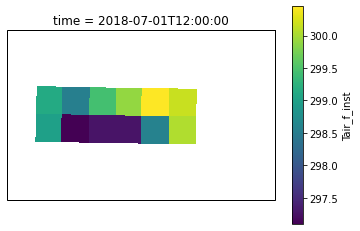

In [23]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_gldas_regrid['Tair_f_inst'].isel(time=4).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [24]:
ds_gldas_daily_mean = ds_gldas_regrid_fill.resample(time='1D').mean()
ds_gldas_daily_max = ds_gldas_regrid_fill.resample(time='1D').max()
ds_gldas_daily_min = ds_gldas_regrid_fill.resample(time='1D').min()

In [25]:
ds_base['gldas_wind_mean'] = ds_gldas_daily_mean['Wind_f_inst']
ds_base['gldas_airT_mean'] = ds_gldas_daily_mean['Tair_f_inst']
ds_base['gldas_airT_max'] = ds_gldas_daily_max['Tair_f_inst']
ds_base['gldas_airT_min'] = ds_gldas_daily_min['Tair_f_inst']
ds_base['gldas_lwdown_mean'] = ds_gldas_daily_mean['LWdown_f_tavg']
ds_base['gldas_pres_mean'] = ds_gldas_daily_mean['Psurf_f_inst']
ds_base['gldas_humidity_mean'] = ds_gldas_daily_mean['Qair_f_inst']
ds_base['gldas_heatflux_mean'] = ds_gldas_daily_mean['Qg_tavg']
ds_base['gldas_rain_max'] = ds_gldas_daily_max['Rainf_f_tavg']
ds_base['gldas_SWdown_max'] = ds_gldas_daily_max['SWdown_f_tavg']


### Add in night time lights

In [36]:
ds_nightlights = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/supplementary_data/nc/VIIRS_nighttime_lights.nc')

In [37]:
ds_nightlights2 = ds_nightlights.drop('crs')

In [38]:
nl_regridder = make_regridder(ds_nightlights2, ds_base_regrid, 'avg_rad')

ds_nl_regrid = nl_regridder(ds_nightlights2)
ds_nl_regrid = ds_nl_regrid.where(ds_nl_regrid['avg_rad']!=0.)

Create weight file: bilinear_79x257_81x241.nc
Remove file bilinear_79x257_81x241.nc
using dimensions ('lat', 'lon') from data variable avg_rad as the horizontal dimensions for this dataset.


In [39]:
ds_nl_regrid.coords['land_mask'] = land_mask

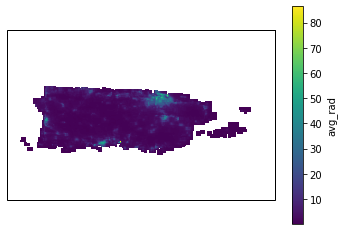

In [40]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_nl_regrid['avg_rad'].where(ds_nl_regrid.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [41]:
ds_base['night_avg_rad'] = ds_nl_regrid['avg_rad']

In [42]:
ds_base

<xarray.Dataset>
Dimensions:                    (lat: 71, lon: 231, time: 364)
Coordinates:
  * lat                        (lat) float64 17.9 17.91 17.92 ... 18.59 18.6
  * lon                        (lon) float64 -67.4 -67.39 ... -65.11 -65.1
  * time                       (time) datetime64[ns] 2018-07-01 ... 2019-06-29
    land_mask                  (lat, lon) float64 nan nan nan ... nan nan nan
Data variables:
    NO2_column_number_density  (time, lat, lon) float64 nan nan nan ... nan nan
    cloud_fraction             (time, lat, lon) float64 nan nan nan ... nan nan
    wind_speed_mean            (time, lat, lon) float64 nan nan nan ... nan nan
    gfs_temp_mean              (time, lat, lon) float64 nan nan nan ... nan nan
    gfs_temp_max               (time, lat, lon) float64 nan nan nan ... nan nan
    gfs_temp_min               (time, lat, lon) float64 nan nan nan ... nan nan
    gfs_humidity_mean          (time, lat, lon) float64 nan nan nan ... nan nan
    gfs_rain_max               (time, lat, lon) float64 nan nan nan ... nan nan
    gldas_wind_mean            (time, lat, lon) float64 1.343 1.343 ... 4.356
    gldas_airT_mean            (time, lat, lon) float64 299.1 299.1 ... 299.9
    gldas_airT_max             (time, lat, lon) float64 304.1 304.1 ... 302.7
    gldas_airT_min             (time, lat, lon) float64 295.1 295.1 ... 297.4
    gldas_lwdown_mean          (time, lat, lon) float64 417.1 417.1 ... 411.0
    gldas_pres_mean            (time, lat, lon) float64 9.948e+04 ... 1.002e+05
    gldas_humidity_mean        (time, lat, lon) float64 0.01586 ... 0.01728
    gldas_heatflux_mean        (time, lat, lon) float64 -0.9397 ... 4.226
    gldas_rain_max             (time, lat, lon) float64 2.5e-05 ... 1.75e-05
    gldas_SWdown_max           (time, lat, lon) float64 978.3 978.3 ... 894.4
    night_avg_rad              (lat, lon) float64 nan nan nan ... 0.1954 nan

### Add in population

In [43]:
ds_population = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/supplementary_data/nc/GPWv411_populationdensity.nc')
ds_population = ds_population.drop('crs')
pop_regridder = make_regridder(ds_population, ds_base_regrid, 'population_density')
ds_pop_regrid = pop_regridder(ds_population)
ds_pop_regrid = ds_pop_regrid.where(ds_pop_regrid['population_density']!=0.)
ds_pop_regrid.coords['land_mask'] = land_mask

Create weight file: bilinear_79x257_81x241.nc
Remove file bilinear_79x257_81x241.nc
using dimensions ('lat', 'lon') from data variable population_density as the horizontal dimensions for this dataset.


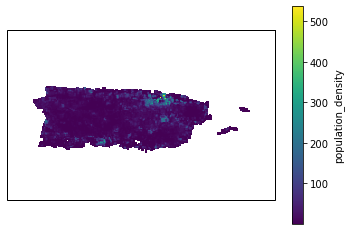

In [44]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_pop_regrid['population_density'].where(ds_pop_regrid.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [45]:
ds_base['population_density'] = ds_pop_regrid['population_density']

### Add in landcover

In [46]:
ds_landcover = xr.open_dataset('/Users/kasmith/Code/kaggle_ds4g/data/supplementary_data/nc/GFSAD1000_landcover.nc')
ds_landcover = ds_landcover.drop('crs')
land_regridder = make_regridder(ds_landcover, ds_base_regrid, 'landcover_category',  'nearest_s2d')
ds_land_regrid = land_regridder(ds_landcover)
ds_land_regrid.coords['land_mask'] = land_mask

Create weight file: nearest_s2d_79x257_81x241.nc
Remove file nearest_s2d_79x257_81x241.nc
using dimensions ('lat', 'lon') from data variable landcover_category as the horizontal dimensions for this dataset.


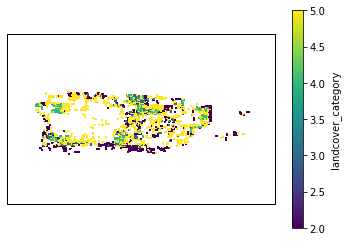

In [47]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_land_regrid['landcover_category'].where(ds_land_regrid.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [48]:
ds_base['landcover_category'] = ds_land_regrid['landcover_category']

### Add power plants layer

In [49]:
plants = pd.read_csv('../data/starter_pack/gppd/gppd_120_pr.csv')
plants = plants[['capacity_mw', 'estimated_generation_gwh', 'primary_fuel', '.geo']]
coordinates = pd.json_normalize(plants['.geo'].apply(json.loads))['coordinates']
plants[['longitude', 'latitude']] = pd.DataFrame(coordinates.values.tolist(), index= coordinates.index)
plants.drop('.geo', axis=1, inplace=True)

In [50]:
plants_fossil = plants[plants['primary_fuel'].isin(['Oil', 'Gas', 'Coal'])].copy()

In [51]:
plants_fossil.reset_index(drop=True, inplace=True)
plants_fossil['grid_lon'] = np.nan
plants_fossil['position_lon'] = np.ones
plants_fossil['grid_lat'] = np.nan
plants_fossil['position_lat'] = np.ones
lons = ds_base.lon.values
a=0 
for lon in plants_fossil.longitude:
    lon_diff = abs(lon-lons) 
    plants_fossil.at[a,'grid_lon'] = lons[np.argmin(lon_diff)]
    plants_fossil.at[a,'position_lon'] = np.argmin(lon_diff)
    a=a+1

lats = ds_base.lat.values
a=0 
for lat in plants_fossil.latitude:
    lat_diff = abs(lat-lats) 
    plants_fossil.at[a,'grid_lat'] = lats[np.argmin(lat_diff)]
    plants_fossil.at[a,'position_lat'] = np.argmin(lat_diff)
    a=a+1

In [52]:
plants_fossil['num_plants'] = 1
plants_fossil_grid = plants_fossil[['grid_lon', 'grid_lat', 'position_lat', 'position_lon', 'num_plants']].groupby(['grid_lon', 'grid_lat', 'position_lat', 'position_lon'], as_index=False).sum()


In [53]:
plants_fossil.to_csv('plants_fossil.csv', index=False)

In [54]:
plants_mask = 0 * np.ones((ds_base.dims['lat'], ds_base.dims['lon'])) * np.isnan(ds_base.NO2_column_number_density.isel(time=0)) 
position_lat_id = 0 * np.ones((ds_base.dims['lat'], ds_base.dims['lon'])) * np.isnan(ds_base.NO2_column_number_density.isel(time=0))
position_lon_id = 0 * np.ones((ds_base.dims['lat'], ds_base.dims['lon'])) * np.isnan(ds_base.NO2_column_number_density.isel(time=0))
plants_mask = plants_mask.drop('time')
count=0
for x in plants_fossil_grid.index:
    plants_mask[(plants_fossil_grid.at[x,'position_lat']-2):(plants_fossil_grid.at[x,'position_lat']+2),(plants_fossil_grid.at[x,'position_lon']-2):(plants_fossil_grid.at[x,'position_lon']+2)]=1
    position_lat_id[(plants_fossil_grid.at[x,'position_lat']-2):(plants_fossil_grid.at[x,'position_lat']+2),(plants_fossil_grid.at[x,'position_lon']-2):(plants_fossil_grid.at[x,'position_lon']+2)]=plants_fossil_grid.at[x,'position_lat']
    position_lon_id[(plants_fossil_grid.at[x,'position_lat']-2):(plants_fossil_grid.at[x,'position_lat']+2),(plants_fossil_grid.at[x,'position_lon']-2):(plants_fossil_grid.at[x,'position_lon']+2)]=plants_fossil_grid.at[x,'position_lon']

    
plants_mask = plants_mask.where(plants_mask == 1.)
position_lat_id = position_lat_id.where(position_lat_id >= 1.)
position_lon_id = position_lon_id.where(position_lon_id >= 1.)
ds_base.coords['plants_mask'] = (('lat', 'lon'), plants_mask)
#ds_base.coords['plants_mask'] = ds_base.plants_mask.where(ds_base.land_mask == 1)
ds_base.coords['no_plants_mask'] = ds_base.plants_mask.fillna(0).where((ds_base.plants_mask != 1) & (ds_base.land_mask == 1))
ds_base.coords['no_plants_mask']  = ds_base.no_plants_mask + 1
ds_base.coords['position_lat_id'] = (('lat', 'lon'), position_lat_id)
ds_base.coords['position_lat_id'] = ds_base.position_lat_id.where(ds_base.position_lat_id >= 1)

ds_base.coords['position_lon_id'] = (('lat', 'lon'), position_lon_id)
ds_base.coords['position_lon_id'] = ds_base.position_lon_id.where(ds_base.position_lon_id >= 1)


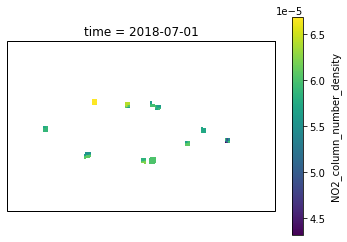

In [55]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base['NO2_column_number_density'].isel(time=0).where((land_mask==1) & (plants_mask==1)).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

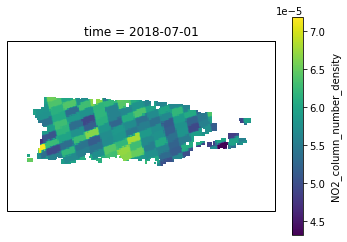

In [56]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base['NO2_column_number_density'].isel(time=0).where(ds_base.no_plants_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

### Calculate Annual Average NO2

In [57]:
ds_base_annual = ds_base.where((ds_base.wind_speed_mean <= 2)).mean(dim=['time'])
ds_base_annual_n = ds_base.where((ds_base.wind_speed_mean <= 2)).count(dim=['time'])

//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


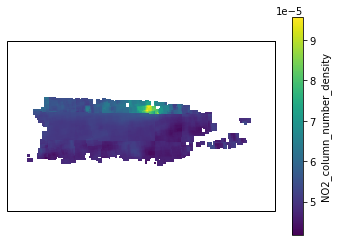

In [58]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_annual['NO2_column_number_density'].where((ds_base_annual.land_mask == 1) & (ds_base_annual.no_plants_mask ==1)).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [59]:
ds_base_annual['n'] = ds_base_annual_n['NO2_column_number_density']

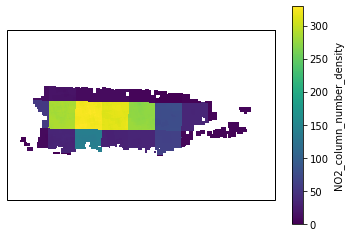

In [60]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_annual_n['NO2_column_number_density'].where((ds_base_annual.land_mask == 1) & (ds_base_annual.no_plants_mask ==1)).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [61]:
ds_base_annual_allwind = ds_base.mean(dim=['time'])

//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


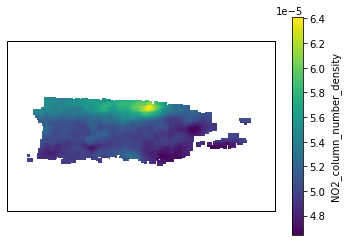

In [62]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_annual_allwind['NO2_column_number_density'].where(ds_base_annual_allwind.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [63]:
ds_base_annual.to_netcdf('annual_low_wind.nc')

In [64]:
ds_base_annual_allwind.to_netcdf('annual_all_wind.nc')

### Calculate monthly average NO2

In [65]:
ds_base_monthly = ds_base.where((ds_base.wind_speed_mean <= 5)).resample(time='1M').mean()

//anaconda/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


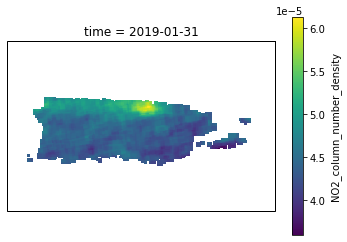

In [66]:
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=-65, central_latitude=18))
ds_base_monthly['NO2_column_number_density'].isel(time=6).where(ds_base_monthly.land_mask == 1).plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_extent([-67.5, -65, 17.5, 19])
ax.set_aspect("equal")

In [67]:
ds_base_monthly.to_netcdf('monthly_all_wind.nc')